In [3]:
import numpy as np
import pandas as pd
from pathlib import Path
import hvplot.pandas
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from datetime import datetime,date
import datetime as dt
from collections import Counter
from matplotlib.ticker import FuncFormatter

import seaborn as sns
plt.style.use('ggplot')

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error

# Needed for decision tree visualization
import pydotplus
from IPython.display import Image


In [2]:
#load the data

file_path = Path('./Resources/serviced_dataframe_w_return.csv')
df = pd.read_csv('serviced_dataframe_w_return.csv')[:-2]


In [3]:
df.shape

(1040752, 37)

In [4]:
list(df)

['id',
 'application_type',
 'desc',
 'loan_amnt',
 'funded_amnt',
 'term',
 'int_rate',
 'grade',
 'sub_grade',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'verification_status',
 'issue_d',
 'loan_status',
 'purpose',
 'dti',
 'delinq_2yrs',
 'earliest_cr_line',
 'open_acc',
 'pub_rec',
 'fico_range_high',
 'fico_range_low',
 'revol_bal',
 'revol_util',
 'total_pymnt',
 'recoveries',
 'last_pymnt_d',
 'year_months',
 'has_desc',
 'credit_hist',
 'loan_length',
 'term_num',
 'ret_low',
 'ret_high',
 'good',
 'emp_length_num']

In [5]:
# Identify the type of each of these column
float_cols = ['loan_amnt', 'funded_amnt','annual_inc',
                     'dti', 'revol_bal', 'delinq_2yrs', 'open_acc', 'pub_rec',
                                'fico_range_high', 'fico_range_low', 'total_pymnt', 'recoveries']
cat_cols = ['term', 'grade', 'sub_grade', 'desc', 'emp_length', 'home_ownership',
                    'verification_status', 'loan_status', 'purpose','application_type']
perc_cols = ['int_rate', 'revol_util','ret_low','ret_high']
date_cols = ['issue_d', 'earliest_cr_line', 'last_pymnt_d', 'year_months']

In [6]:
#define the loan status

#d =  {'Fully Paid':0, 'Charged Off':1, 'Default':1}

#df['loan_status'] = df['loan_status']. map(d)

In [7]:
#new FICO average

df['fico_avg'] = (df.fico_range_high + df.fico_range_low)/2

In [8]:
columns = [
 'application_type',
 'loan_amnt',
 'funded_amnt',
 'int_rate',
 'grade',
 'sub_grade',
 'home_ownership',
 'annual_inc',
 'verification_status',
 'purpose',
 'dti',
 'delinq_2yrs',
 'open_acc',
 'pub_rec',
 'fico_avg',
 'revol_bal',
 'revol_util',
 'total_pymnt',
 'recoveries',
 'last_pymnt_d',
 'has_desc',
 'credit_hist',
 'loan_length',
 'term',
 'ret_low',
 'ret_high',
 'good',
 'emp_length_num'
]

target = ["good"]



In [9]:
df = df.loc[:, columns].copy()

In [10]:
# Create our features
X = df.copy()
X.drop('good', axis=1, inplace=True)

# Create our target
y = df['good']


In [11]:
to_drop = ['recoveries', 'total_pymnt', 'dti','last_pymnt_d',
         'revol_util', 'open_acc', 'pub_rec', 'revol_bal',
         'revol_util', 'delinq_2yrs']

X.drop(to_drop, axis=1, inplace=True)


In [12]:
app =  {'Individual':0, 'Joint App':1}

X['application_type'] = X['application_type']. map(app)

In [13]:
grade =  {'A':1, 'B':2, 'C':3, 'D':4, 'E':5, 'F':6, 'G':7}

X['grade'] = X['grade']. map(grade)

In [14]:
t =  {' 36 months':0, ' 60 months':1}

X['term'] = X['term']. map(t)

In [15]:
v =  {'Not Verified':0, 'Source Verified':1, 'Verified':2}

X['verification_status'] = X['verification_status']. map(v)

In [16]:
d =  {False:0, True:1}

X['has_desc'] = X['has_desc']. map(d)

In [17]:
sub_grades = sorted(df.sub_grade.unique())
sub_grades_dict = {x:sub_grades.index(x)+1 for x in sub_grades} 

X['sub_grade'] = X['sub_grade']. map(sub_grades_dict)

In [18]:
X.sample(3).T

319459            850610       956379
application_type                      0                 0            0
loan_amnt                          9025              5000        15000
funded_amnt                        9025              5000        15000
int_rate                         0.1655            0.0839       0.1399
grade                                 4                 2            3
sub_grade                            17                 6           13
home_ownership                 MORTGAGE          MORTGAGE     MORTGAGE
annual_inc                        18081             42000       130000
verification_status                   1                 0            1
purpose              debt_consolidation  home_improvement  credit_card
fico_avg                            692               677          682
has_desc                              0                 0            0
credit_hist                          25                23           22
loan_length                      36.009           29.9965      18.9573
term                                  0                 0            0
ret_low                        0.091203         0.0388639    -0.101799
ret_high                      0.0911803         0.0466422    -0.101799
emp_length_num                        8                10            0

In [19]:
cat_col = ['home_ownership','purpose']

X = pd.get_dummies(X, columns=cat_col)

In [20]:
X.describe()

application_type     loan_amnt   funded_amnt      int_rate  \
count      1.040752e+06  1.040752e+06  1.040752e+06  1.040752e+06   
mean       7.756891e-03  1.472380e+04  1.472378e+04  1.294675e-01   
std        8.773100e-02  8.685624e+03  8.685624e+03  4.576142e-02   
min        0.000000e+00  1.000000e+03  1.000000e+03  5.320000e-02   
25%        0.000000e+00  8.000000e+03  8.000000e+03  9.170000e-02   
50%        0.000000e+00  1.270000e+04  1.270000e+04  1.269000e-01   
75%        0.000000e+00  2.000000e+04  2.000000e+04  1.561000e-01   
max        1.000000e+00  4.000000e+04  4.000000e+04  3.099000e-01   

              grade     sub_grade    annual_inc  verification_status  \
count  1.040752e+06  1.040752e+06  1.040752e+06         1.040752e+06   
mean   2.753028e+00  1.171417e+01  7.711343e+04         1.010963e+00   
std    1.283666e+00  6.382068e+00  7.162064e+04         7.552677e-01   
min    1.000000e+00  1.000000e+00  0.000000e+00         0.000000e+00   
25%    2.000000e+00  7.000000e+00  4.600000e+04         0.000000e+00   
50%    3.000000e+00  1.100000e+01  6.500000e+04         1.000000e+00   
75%    4.000000e+00  1.600000e+01  9.200000e+04         2.000000e+00   
max    7.000000e+00  3.500000e+01  9.573072e+06         2.000000e+00   

           fico_avg      has_desc  ...  purpose_home_improvement  \
count  1.040752e+06  1.040752e+06  ...              1.040752e+06   
mean   6.959455e+02  1.473069e-02  ...              6.354252e-02   
std    3.048848e+01  1.204729e-01  ...              2.439363e-01   
min    6.620000e+02  0.000000e+00  ...              0.000000e+00   
25%    6.720000e+02  0.000000e+00  ...              0.000000e+00   
50%    6.870000e+02  0.000000e+00  ...              0.000000e+00   
75%    7.120000e+02  0.000000e+00  ...              0.000000e+00   
max    8.475000e+02  1.000000e+00  ...              1.000000e+00   

       purpose_house  purpose_major_purchase  purpose_medical  purpose_moving  \
count   1.040752e+06            1.040752e+06     1.040752e+06    1.040752e+06   
mean    3.820315e-03            1.986544e-02     1.082102e-02    6.519324e-03   
std     6.169055e-02            1.395379e-01     1.034598e-01    8.047875e-02   
min     0.000000e+00            0.000000e+00     0.000000e+00    0.000000e+00   
25%     0.000000e+00            0.000000e+00     0.000000e+00    0.000000e+00   
50%     0.000000e+00            0.000000e+00     0.000000e+00    0.000000e+00   
75%     0.000000e+00            0.000000e+00     0.000000e+00    0.000000e+00   
max     1.000000e+00            1.000000e+00     1.000000e+00    1.000000e+00   

       purpose_other  purpose_renewable_energy  purpose_small_business  \
count   1.040752e+06              1.040752e+06            1.040752e+06   
mean    5.376497e-02              6.043707e-04            9.622850e-03   
std     2.255534e-01              2.457653e-02            9.762305e-02   
min     0.000000e+00              0.000000e+00            0.000000e+00   
25%     0.000000e+00              0.000000e+00            0.000000e+00   
50%     0.000000e+00              0.000000e+00            0.000000e+00   
75%     0.000000e+00              0.000000e+00            0.000000e+00   
max     1.000000e+00              1.000000e+00            1.000000e+00   

       purpose_vacation  purpose_wedding  
count      1.040752e+06     1.040752e+06  
mean       6.310821e-03     1.345181e-05  
std        7.918965e-02     3.667648e-03  
min        0.000000e+00     0.000000e+00  
25%        0.000000e+00     0.000000e+00  
50%        0.000000e+00     0.000000e+00  
75%        0.000000e+00     0.000000e+00  
max        1.000000e+00     1.000000e+00  

[8 rows x 34 columns]

In [21]:
# Splitting into Train and Test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=79)


In [22]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(780564, 34)
(260188, 34)
(780564,)
(260188,)


In [23]:
# Creating StandardScaler instance
scaler = StandardScaler()


In [24]:
# Fitting Standard Scaller
X_scaler = scaler.fit(X_train)


In [25]:

# Scaling data
X_train_scaled = X_scaler.fit_transform(X_train)
X_test_scaled = X_scaler.transform(X_test)



## RANDOM FOREST CLASSIFIER

In [27]:
# Create a random forest classifier
rf_model = RandomForestClassifier(n_estimators=500, random_state=34)



In [28]:
X_train_scaled.dtype

dtype('float64')

In [29]:
# Fitting the model
rf_model = rf_model.fit(X_train_scaled, y_train)


In [30]:
# Making predictions using the testing data
predictions = rf_model.predict(X_test_scaled)


In [36]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)

cm_df

Predicted 0  Predicted 1
Actual 0        49128          733
Actual 1           37       210290

In [32]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix


Predicted 0  Predicted 1
Actual 0        49128          733
Actual 1           37       210290

Accuracy Score : 0.9970406014112873
Classification Report
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     49861
           1       1.00      1.00      1.00    210327

    accuracy                           1.00    260188
   macro avg       1.00      0.99      1.00    260188
weighted avg       1.00      1.00      1.00    260188



In [37]:
# Random Forests in sklearn will automatically calculate feature importance
importances = rf_model.feature_importances_



In [38]:
# We can sort the features by their importance
sorted(zip(rf_model.feature_importances_, X.columns), reverse=True)


[(0.5072084087668329, 'ret_high'),
 (0.3984117101022582, 'ret_low'),
 (0.03422689042518829, 'loan_length'),
 (0.01364801149378715, 'int_rate'),
 (0.012637834154459302, 'sub_grade'),
 (0.010015355237867344, 'grade'),
 (0.004786466724658715, 'term'),
 (0.003382539515443186, 'fico_avg'),
 (0.002901450964429135, 'annual_inc'),
 (0.0026171940641910307, 'loan_amnt'),
 (0.002518879227849361, 'funded_amnt'),
 (0.002026367606776717, 'credit_hist'),
 (0.0011622780232199272, 'verification_status'),
 (0.0011611270596743072, 'emp_length_num'),
 (0.0008429288454857738, 'home_ownership_MORTGAGE'),
 (0.0006810527385217322, 'home_ownership_RENT'),
 (0.00031922909810959665, 'purpose_debt_consolidation'),
 (0.00027939910330598166, 'purpose_credit_card'),
 (0.00019506055262958082, 'home_ownership_OWN'),
 (0.00017481708994912228, 'purpose_other'),
 (0.00015996664099102132, 'purpose_home_improvement'),
 (0.0001103918836345132, 'purpose_major_purchase'),
 (9.271838620103438e-05, 'has_desc'),
 (8.399530900091

## DECISION TREE

In [46]:
# Creating the decision tree classifier instance
dt_model = tree.DecisionTreeClassifier()

# Fitting the model
dt_model = dt_model.fit(X_train_scaled, y_train)

# Making predictions using the testing data
dt_predictions = dt_model.predict(X_test_scaled)



In [47]:
# Calculating the confusion matrix
dt_cm = confusion_matrix(y_test, dt_predictions)
dt_cm_df = pd.DataFrame(
    dt_cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score
dt_acc_score = accuracy_score(y_test, dt_predictions)



In [48]:
# Displaying results
print("Confusion Matrix")
display(dt_cm_df)
print(f"Accuracy Score : {dt_acc_score}")
print("Classification Report")
print(classification_report(y_test, dt_predictions))


Confusion Matrix


Predicted 0  Predicted 1
Actual 0        49378          483
Actual 1          510       209817

Accuracy Score : 0.9961835288329977
Classification Report
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     49861
           1       1.00      1.00      1.00    210327

    accuracy                           1.00    260188
   macro avg       0.99      0.99      0.99    260188
weighted avg       1.00      1.00      1.00    260188



In [49]:
# Create DOT data
dot_data = tree.export_graphviz(
    dt_model, out_file=None, feature_names=X.columns, class_names=["0", "1"], filled=True
)

# Draw graph
graph = pydotplus.graph_from_dot_data(dot_data)

# Show graph
Image(graph.create_png())

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.329115 to fit



## LOGISTIC REGRESSION

In [64]:
lr_classifier = LogisticRegression(solver='lbfgs', random_state=34)
lr_classifier

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=34, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [65]:
# Train the data
lr_classifier.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=34, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [66]:
# Score the model
print(f"Training Data Score: {lr_classifier.score(X_train, y_train)}")
print(f"Testing Data Score: {lr_classifier.score(X_test, y_test)}")

Training Data Score: 0.8056443802173813
Testing Data Score: 0.8060671514443403


In [67]:
lr_cm= confusion_matrix(y_test, lr_predictions)
lr_cm_df = pd.DataFrame(
    lr_cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

In [68]:
lr_predictions = lr_classifier.predict(X_test)

In [69]:
# Calculating the accuracy score
lr_acc_score = accuracy_score(y_test, lr_predictions)


In [70]:
# Displaying results
print("Confusion Matrix")
display(lr_cm_df)
print(f"Accuracy Score : {lr_acc_score}")
print("Classification Report")
print(classification_report(y_test, lr_predictions))

Confusion Matrix


Predicted 0  Predicted 1
Actual 0         2357        47504
Actual 1         2955       207372

Accuracy Score : 0.8060671514443403
Classification Report
              precision    recall  f1-score   support

           0       0.44      0.05      0.09     49861
           1       0.81      0.99      0.89    210327

    accuracy                           0.81    260188
   macro avg       0.63      0.52      0.49    260188
weighted avg       0.74      0.81      0.74    260188



In [72]:
# Predict outcomes for test data set
#pd.DataFrame({"Prediction": lr_predictions, "Actual": y_test})

In [76]:
from sklearn.metrics import precision_recall_curve


probs_lr = lr_classifier.predict_proba(X_test)[:, 1]
probs_rf = rf_model.predict_proba(X_test)[:, 1]
#probs_dt = dt_model.predict_proba(X_test)[:, 1]
precision_lr, recall_lr, _ = precision_recall_curve(y_test, probs_lr, pos_label=1)
precision_rf, recall_rf, _ = precision_recall_curve(y_test, probs_rf, pos_label=1)
#precision_dt, recall_dt, _ = precision_recall_curve(y_test, probs_dt, pos_label=1)

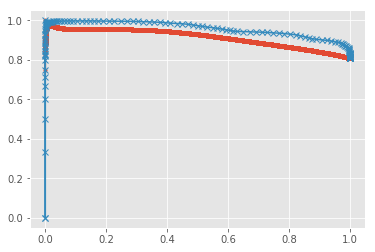

In [77]:
plt.plot(recall_lr, precision_lr, marker='.')
plt.plot(recall_rf, precision_rf, marker='x')
#plt.plot(recall_dt, precision_rf, marker='v')